# Predict Sale Price - Regression

## Objectives

* Fit and evaluate a regression model to predict Sale price for a house.

## Inputs

* outputs/datasets/cleaned/HousePricesRecordsCleaned.csv

## Outputs

* Train set (features and target)
* Test set (features and target)
* ML pipline to predict Sale price
* Feature Importance Plot

---

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/milestone-project-heritage-housing-issues/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspaces/milestone-project-heritage-housing-issues'

# Load the data

In [4]:
import numpy as np
import pandas as pd
df = pd.read_csv("outputs/datasets/cleaned/HousePricesRecordsCleaned.csv")
print(df.shape)
df.head()

(1460, 22)


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,548,RFn,2003.0,...,8450,65.0,196.0,61,5,7,856,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,460,RFn,1976.0,...,9600,80.0,0.0,0,8,6,1262,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,608,RFn,2001.0,...,11250,68.0,162.0,42,5,7,920,2001,2002,223500
3,961,0.0,3.0,No,216,ALQ,540,642,Unf,1998.0,...,9550,60.0,0.0,35,5,7,756,1915,1970,140000
4,1145,0.0,4.0,Av,655,GLQ,490,836,RFn,2000.0,...,14260,84.0,350.0,84,5,8,1145,2000,2000,250000


---

# ML Pipeline: Regressor

## Create ML pipeline

In [5]:
from sklearn.pipeline import Pipeline

# Feature Engineering
from feature_engine.encoding import OrdinalEncoder
from feature_engine.selection import SmartCorrelatedSelection
from feature_engine import transformation as vt

# Feat Scaling
from sklearn.preprocessing import StandardScaler

# Feat Selection
from sklearn.feature_selection import SelectFromModel

# ML algorithms
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor


def PipelineOptimization(model):
    pipeline_base = Pipeline([

        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual'])),

        ("NumericYeoJohnsonTransformer", vt.YeoJohnsonTransformer(variables=['1stFlrSF', 'GrLivArea', 'LotArea'])),


        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
         method="spearman", threshold=0.6, selection_method="variance")),

        ("feat_scaling", StandardScaler()),

        ("feat_selection",  SelectFromModel(model)),

        ("model", model),

    ])

    return pipeline_base

Custom Class for hyperparameter optimisation

In [6]:
from sklearn.model_selection import GridSearchCV


class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model = PipelineOptimization(self.models[key])

            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring)
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns], self.grid_searches

# Split Train Test Set

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['SalePrice'], axis=1),
    df['SalePrice'],
    test_size=0.2,
    random_state=0
)

print("* Train set:", X_train.shape, y_train.shape,
      "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (1168, 21) (1168,) 
* Test set: (292, 21) (292,)


# Grid Search CV -Sklearn

## Use default hyperparameters to find the most suitable algorithum

In [8]:
models_quick_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

Do a hyperparameter optimisation search using default hyperparameters

In [9]:
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Lets check the results

In [10]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
5,GradientBoostingRegressor,0.643137,0.775863,0.849164,0.070342
0,LinearRegression,0.724999,0.75977,0.830006,0.03798
3,ExtraTreesRegressor,0.682734,0.759051,0.792093,0.040241
2,RandomForestRegressor,0.618654,0.753094,0.822354,0.070283
4,AdaBoostRegressor,0.623871,0.713012,0.783664,0.056683
6,XGBRegressor,0.637822,0.673709,0.705092,0.02613
1,DecisionTreeRegressor,0.355924,0.500681,0.648757,0.094411


Extensive seach for the best hyperparameter configuration

In [11]:
models_search = {
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
}

params_search = {
    "GradientBoostingRegressor": {
        'model__n_estimators': [100,300,500],
        'model__learning_rate': [1e-1,1e-2,1e-3], 
        'model__max_depth': [3,10,None],
    }
}

In [12]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 27 candidates, totalling 135 fits


In [13]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__learning_rate,model__max_depth,model__n_estimators
11,GradientBoostingRegressor,0.672883,0.779617,0.842019,0.060238,0.01,3,500
0,GradientBoostingRegressor,0.643137,0.775863,0.849164,0.070342,0.1,3,100
10,GradientBoostingRegressor,0.700005,0.773797,0.822879,0.0474,0.01,3,300
1,GradientBoostingRegressor,0.599566,0.763971,0.854437,0.086566,0.1,3,300
2,GradientBoostingRegressor,0.580969,0.758179,0.850534,0.092709,0.1,3,500
13,GradientBoostingRegressor,0.481152,0.716687,0.803333,0.119101,0.01,10,300
14,GradientBoostingRegressor,0.458438,0.714566,0.801526,0.129427,0.01,10,500
3,GradientBoostingRegressor,0.459728,0.711646,0.80047,0.127036,0.1,10,100
4,GradientBoostingRegressor,0.458818,0.711371,0.800217,0.12735,0.1,10,300
5,GradientBoostingRegressor,0.458782,0.711357,0.800213,0.127362,0.1,10,500


check the best model

In [14]:
best_model = grid_search_summary.iloc[0, 0]
best_model

'GradientBoostingRegressor'

Best parameters

In [15]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{'model__learning_rate': 0.01,
 'model__max_depth': 3,
 'model__n_estimators': 500}

Best regressor, based on search

In [16]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['BsmtExposure', 'BsmtFinType1',
                                           'GarageFinish', 'KitchenQual'])),
                ('NumericYeoJohnsonTransformer',
                 YeoJohnsonTransformer(variables=['1stFlrSF', 'GrLivArea',
                                                  'LotArea'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method=...
                                                     'GarageYrBlt', 'GrLivArea',
                                                     'KitchenQual', 'LotArea',
                                                     'LotFrontage',
                                                     'MasVnrArea',
                                                     'OpenPorchSF',
                     

# Assess feature importance

* These are the 4 most important features in descending order. The model was trained on them: 
['OverallQual', 'TotalBsmtSF', '2ndFlrSF', 'GarageArea']


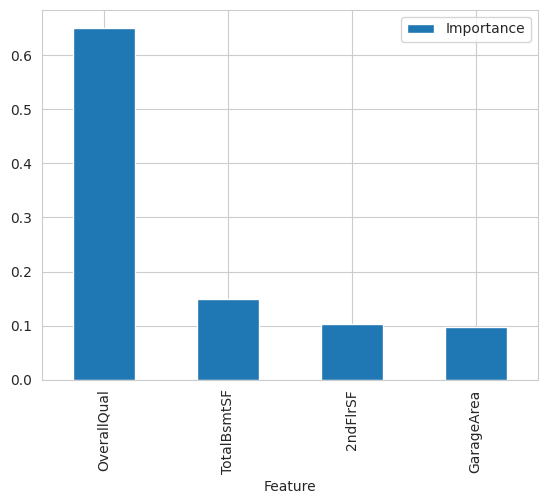

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# after data cleaning and feature engineering, the features may have changes
# how many data cleaning and feature engineering steps does your pipeline have?
data_cleaning_feat_eng_steps = 3
columns_after_data_cleaning_feat_eng = (Pipeline(best_regressor_pipeline.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support(
)].to_list()

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()],
    'Importance': best_regressor_pipeline['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

# Evaluate on Train and Test Sets

In [18]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np


def regression_performance(X_train, y_train, X_test, y_test, pipeline):
    print("Model Evaluation \n")
    print("* Train Set")
    regression_evaluation(X_train, y_train, pipeline)
    print("* Test Set")
    regression_evaluation(X_test, y_test, pipeline)


def regression_evaluation(X, y, pipeline):
    prediction = pipeline.predict(X)
    print('R2 Score:', r2_score(y, prediction).round(3))
    print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))
    print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))
    print('Root Mean Squared Error:', np.sqrt(
        mean_squared_error(y, prediction)).round(3))
    print("\n")


def regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5):
    pred_train = pipeline.predict(X_train)
    pred_test = pipeline.predict(X_test)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color='red', ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set")

    sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1])
    sns.lineplot(x=y_test, y=y_test, color='red', ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Test Set")

    plt.show()

Model Evaluation 

* Train Set
R2 Score: 0.886
Mean Absolute Error: 19205.715
Mean Squared Error: 702066634.189
Root Mean Squared Error: 26496.54


* Test Set
R2 Score: 0.839
Mean Absolute Error: 22301.333
Mean Squared Error: 1111294272.607
Root Mean Squared Error: 33336.081




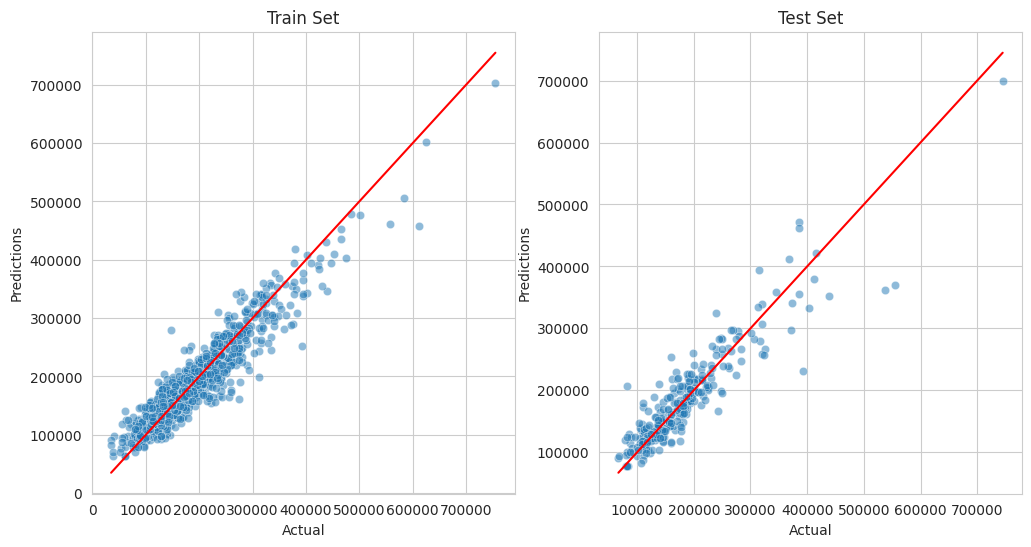

In [19]:
regression_performance(X_train, y_train, X_test, y_test, best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline)

---

# Regressor with PCA

In [20]:
pipeline = PipelineOptimization(model=GradientBoostingRegressor())
pipeline_pca = Pipeline(pipeline.steps[:4])
df_pca = pipeline_pca.fit_transform(df.drop(['SalePrice'], axis=1))

print(df_pca.shape,'\n', type(df_pca))

(1460, 17) 
 <class 'numpy.ndarray'>


* The 17 components explain 100.0% of the data 



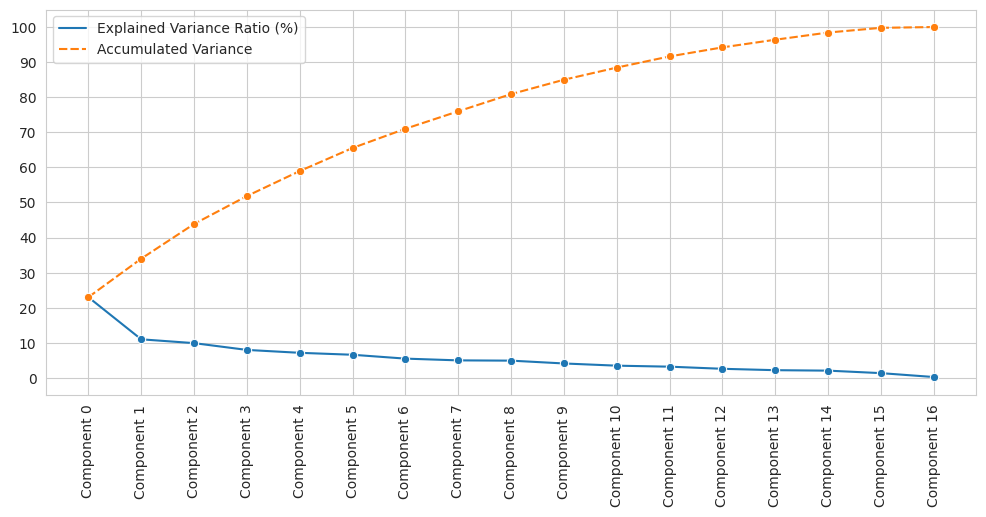

In [21]:
import numpy as np
from sklearn.decomposition import PCA

n_components = 17


def pca_components_analysis(df_pca, n_components):
    pca = PCA(n_components=n_components).fit(df_pca)
    x_PCA = pca.transform(df_pca)  # array with transformed PCA

    ComponentsList = ["Component " + str(number)
                      for number in range(n_components)]
    dfExplVarRatio = pd.DataFrame(
        data=np.round(100 * pca.explained_variance_ratio_, 3),
        index=ComponentsList,
        columns=['Explained Variance Ratio (%)'])

    dfExplVarRatio['Accumulated Variance'] = dfExplVarRatio['Explained Variance Ratio (%)'].cumsum(
    )

    PercentageOfDataExplained = dfExplVarRatio['Explained Variance Ratio (%)'].sum(
    )

    print(
        f"* The {n_components} components explain {round(PercentageOfDataExplained,2)}% of the data \n")
    plt.figure(figsize=(12, 5))
    sns.lineplot(data=dfExplVarRatio,  marker="o")
    plt.xticks(rotation=90)
    plt.yticks(np.arange(0, 110, 10))
    plt.show()


pca_components_analysis(df_pca=df_pca, n_components=n_components)

* The 8 components explain 75.98% of the data 



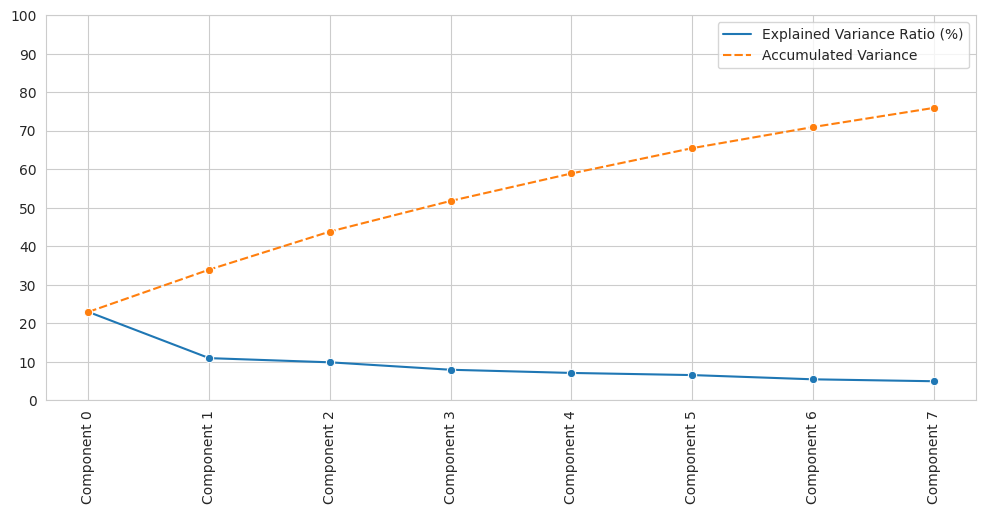

In [22]:
n_components = 8
pca_components_analysis(df_pca=df_pca, n_components=n_components)

# Rewrite the ML Pipeline for Modelling

In [23]:
from sklearn.decomposition import PCA

def PipelineOptimization(model):
    pipeline_base = Pipeline([

        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual'])),

        ("NumericYeoJohnsonTransformer", vt.YeoJohnsonTransformer(variables=['1stFlrSF', 'GrLivArea', 'LotArea'])),


        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
         method="spearman", threshold=0.6, selection_method="variance")),

        ("feat_scaling", StandardScaler()),

        ("PCA", PCA(n_components=8, random_state=0)),

        ("model", model),

    ])

    return pipeline_base

Standard hyperpara,eters to find the best model

In [24]:
models_quick_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

In [25]:
quick_search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
quick_search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [26]:
grid_search_summary, grid_search_pipelines = quick_search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
2,RandomForestRegressor,0.70974,0.754552,0.797066,0.035031
3,ExtraTreesRegressor,0.657283,0.752858,0.814209,0.055672
5,GradientBoostingRegressor,0.652322,0.747079,0.79356,0.049743
6,XGBRegressor,0.629996,0.727265,0.789538,0.054009
0,LinearRegression,0.660035,0.719702,0.76118,0.038629
4,AdaBoostRegressor,0.662858,0.700658,0.752985,0.030769
1,DecisionTreeRegressor,0.486435,0.543696,0.592309,0.0391


In [27]:
models_search_pca = {
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
}

params_search_pca = {
    "RandomForestRegressor": {
        'model__n_estimators': [100,300,500],
        'model__max_depth': [3,10,None],
    }
}

In [28]:
search = HyperparameterOptimizationSearch(models=models_search_pca, params=params_search_pca)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 9 candidates, totalling 45 fits


In [29]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__n_estimators
8,RandomForestRegressor,0.710012,0.756154,0.799001,0.034381,None,500
7,RandomForestRegressor,0.707393,0.755374,0.799558,0.034657,None,300
5,RandomForestRegressor,0.709439,0.755175,0.79825,0.03369,10,500
4,RandomForestRegressor,0.708325,0.75477,0.798156,0.033932,10,300
6,RandomForestRegressor,0.70974,0.754552,0.797066,0.035031,None,100
3,RandomForestRegressor,0.70816,0.754541,0.79683,0.035502,10,100
0,RandomForestRegressor,0.659273,0.701655,0.748926,0.030254,3,100
1,RandomForestRegressor,0.65259,0.699853,0.747195,0.031629,3,300
2,RandomForestRegressor,0.651667,0.698995,0.745905,0.03164,3,500


In [30]:
best_model_pca = grid_search_summary.iloc[0,0]
best_model_pca

'RandomForestRegressor'

In [31]:
best_parameters_pca = grid_search_pipelines[best_model_pca].best_params_
best_parameters_pca

{'model__max_depth': None, 'model__n_estimators': 500}

In [32]:
best_regressor_pipeline_pca = grid_search_pipelines[best_model_pca].best_estimator_
best_regressor_pipeline_pca

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['BsmtExposure', 'BsmtFinType1',
                                           'GarageFinish', 'KitchenQual'])),
                ('NumericYeoJohnsonTransformer',
                 YeoJohnsonTransformer(variables=['1stFlrSF', 'GrLivArea',
                                                  'LotArea'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method=...
                                                     'BsmtFinType1',
                                                     'BsmtUnfSF', 'GarageArea',
                                                     'GarageFinish',
                                                     'GarageYrBlt', 'GrLivArea',
                                                     'KitchenQual', 'LotArea',
      

# Evaluate Regressor on Train and Test Sets

Model Evaluation 

* Train Set
R2 Score: 0.971
Mean Absolute Error: 8224.275
Mean Squared Error: 181262898.569
Root Mean Squared Error: 13463.391


* Test Set
R2 Score: 0.774
Mean Absolute Error: 23401.717
Mean Squared Error: 1563985928.832
Root Mean Squared Error: 39547.262




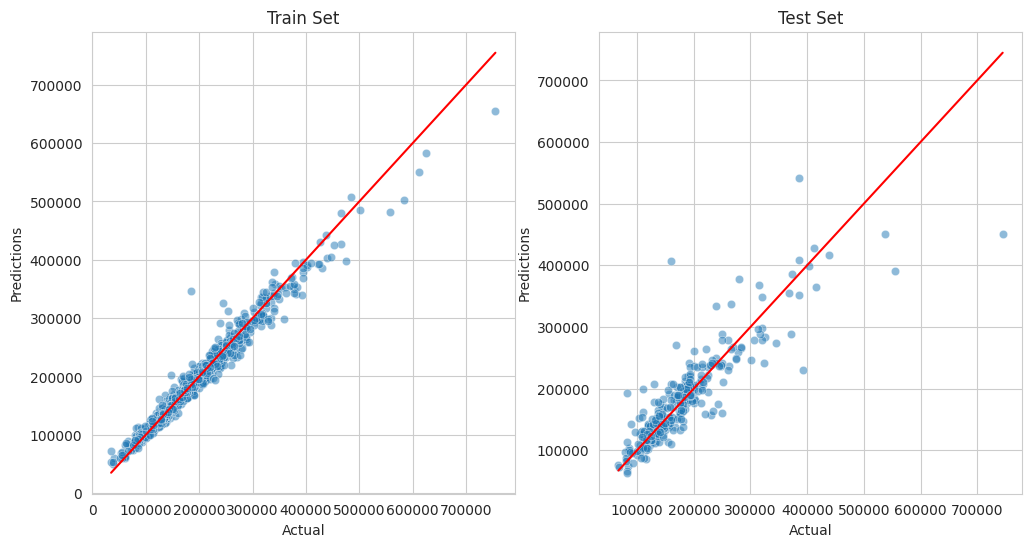

In [33]:
regression_performance(X_train, y_train, X_test, y_test,best_regressor_pipeline_pca)
regression_evaluation_plots(X_train, y_train, X_test, y_test,
                            best_regressor_pipeline_pca)

---

# Which pipeline to choose?

We have fitted 2 pipelines:
* Regression
* Regression with PCA

The Regression pipeline reached the required performace thershold with an 0.839 R2 score. Both Train and Test set achieved a similar R2 score meaning the pipeline did not overfit the model.

The Regression with PCA pipeline also rached the required performace thershold with an 0.774 R2 score. However there was a 0.2 difference in R2 score suggesting that the model was overfitting. 

Therefore the best Pipeline to choose would be the Regression Pipeline. 

In [34]:
best_regressor_pipeline

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['BsmtExposure', 'BsmtFinType1',
                                           'GarageFinish', 'KitchenQual'])),
                ('NumericYeoJohnsonTransformer',
                 YeoJohnsonTransformer(variables=['1stFlrSF', 'GrLivArea',
                                                  'LotArea'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method=...
                                                     'GarageYrBlt', 'GrLivArea',
                                                     'KitchenQual', 'LotArea',
                                                     'LotFrontage',
                                                     'MasVnrArea',
                                                     'OpenPorchSF',
                     

---

# Refit the pipeline with the best features

## Rewrite the pipeline

In [35]:
def PipelineOptimization(model):
    pipeline_base = Pipeline([

        ("feat_scaling", StandardScaler()),

        ("model", model),

    ])

    return pipeline_base

# Split Train Test Set, only with best features

In [36]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['SalePrice'], axis=1),
    df['SalePrice'],
    test_size=0.2,
    random_state=0
)

print("* Train set:", X_train.shape, y_train.shape,
      "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (1168, 21) (1168,) 
* Test set: (292, 21) (292,)


Our best features are:

In [37]:
best_features

['2ndFlrSF', 'GarageArea', 'OverallQual', 'TotalBsmtSF']

In [38]:
X_train = X_train.filter(best_features)
X_test = X_test.filter(best_features)

print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)
X_train.head()

* Train set: (1168, 4) (1168,) 
* Test set: (292, 4) (292,)


,2ndFlrSF,GarageArea,OverallQual,TotalBsmtSF
618,0.0,774,9,1822
870,0.0,308,5,894
92,0.0,432,5,876
817,0.0,857,8,1568
302,0.0,843,7,1541


# Grid Search CV - Sklearn

In [39]:
models_search

{'GradientBoostingRegressor': GradientBoostingRegressor(random_state=0)}

In [40]:
best_parameters

{'model__learning_rate': 0.01,
 'model__max_depth': 3,
 'model__n_estimators': 500}

In [41]:
params_search = {
    "GradientBoostingRegressor": {
        'model__n_estimators': [500],
        'model__learning_rate': [1e-2], 
        'model__max_depth': [3],
    }
}
params_search

{'GradientBoostingRegressor': {'model__n_estimators': [500],
  'model__learning_rate': [0.01],
  'model__max_depth': [3]}}

In [42]:
from sklearn.metrics import make_scorer, recall_score
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [43]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__learning_rate,model__max_depth,model__n_estimators
0,GradientBoostingRegressor,0.672883,0.785792,0.819531,0.056794,0.01,3,500


In [44]:
best_model = grid_search_summary.iloc[0,0]
best_model

'GradientBoostingRegressor'

In [45]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('feat_scaling', StandardScaler()),
                ('model',
                 GradientBoostingRegressor(learning_rate=0.01, n_estimators=500,
                                           random_state=0))])

* These are the 4 most important features in descending order. The model was trained on them: 
['OverallQual', 'TotalBsmtSF', '2ndFlrSF', 'GarageArea']


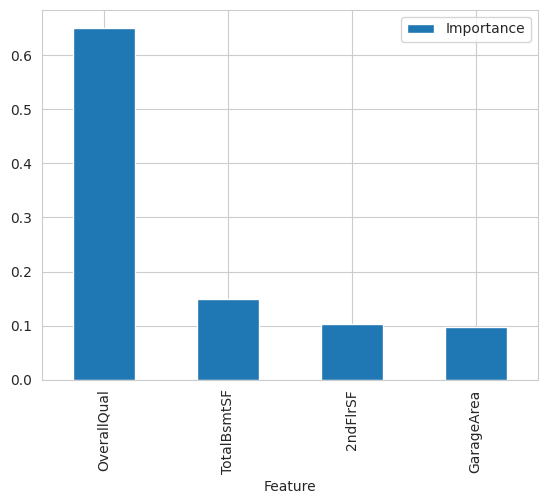

In [48]:
# how many data cleaning and feature engineering does your pipeline have?
columns_after_data_cleaning_feat_eng = (X_train
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': columns_after_data_cleaning_feat_eng,
    'Importance': best_regressor_pipeline['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

# Evaluate Regression on Train and Test Sets

Model Evaluation 

* Train Set
R2 Score: 0.886
Mean Absolute Error: 19205.715
Mean Squared Error: 702066634.189
Root Mean Squared Error: 26496.54


* Test Set
R2 Score: 0.839
Mean Absolute Error: 22301.333
Mean Squared Error: 1111294272.607
Root Mean Squared Error: 33336.081




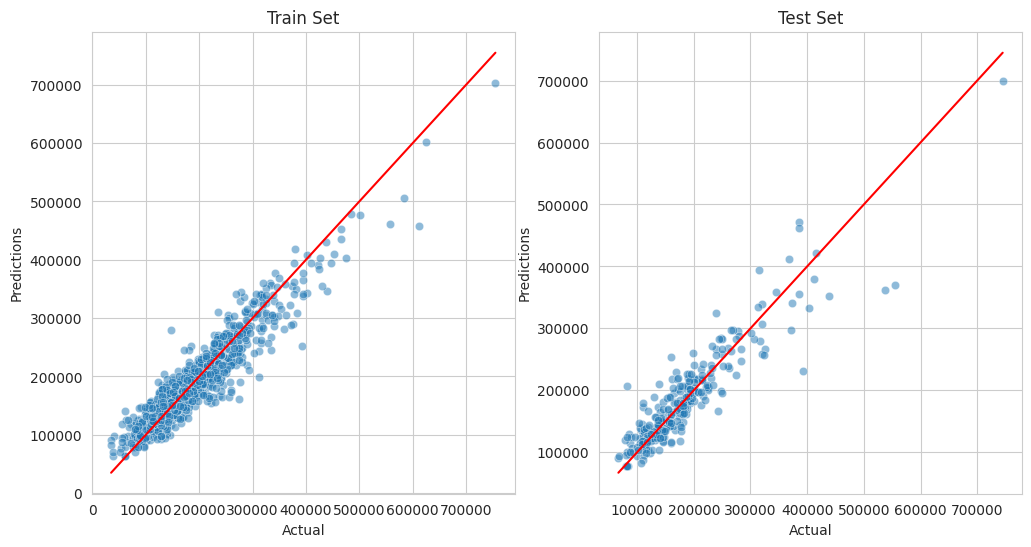

In [49]:
regression_performance(X_train, y_train, X_test, y_test, best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline)

---

# Push files to Repo

We will generate these files:
* Train set
* Test set
* Modeling pipeline
* Features importance plot

In [50]:
import joblib
import os

version = 'v1'
file_path = f'outputs/ml_pipeline/predict_sale_price/{version}'

try:
  os.makedirs(name=file_path)
except Exception as e:
  print(e)

## Train Set: Features and targets

In [51]:
X_train.head()

,2ndFlrSF,GarageArea,OverallQual,TotalBsmtSF
618,0.0,774,9,1822
870,0.0,308,5,894
92,0.0,432,5,876
817,0.0,857,8,1568
302,0.0,843,7,1541


In [52]:
X_train.to_csv(f"{file_path}/X_train.csv", index=False)

In [53]:
y_train

618     314813
870     109500
92      163500
817     271000
302     205000
         ...  
763     337000
835     128000
1216    112000
559     234000
684     221000
Name: SalePrice, Length: 1168, dtype: int64

In [54]:
y_train.to_csv(f"{file_path}/Y_train.csv", index=False)

## Test Set: Features and target

In [55]:
X_test.head()

,2ndFlrSF,GarageArea,OverallQual,TotalBsmtSF
529,0.0,484,6,2035
491,620.0,240,6,806
459,224.0,352,5,709
279,866.0,505,7,1160
655,0.0,264,6,525


In [56]:
X_test.to_csv(f"{file_path}/X_test.csv", index=False)

In [57]:
y_test

529     200624
491     133000
459     110000
279     192000
655      88000
         ...  
326     324000
440     555000
1387    136000
1323     82500
61      101000
Name: SalePrice, Length: 292, dtype: int64

In [58]:
y_test.to_csv(f"{file_path}/Y_test.csv", index=False)

## Modelling pipeline

In [59]:
best_regressor_pipeline

Pipeline(steps=[('feat_scaling', StandardScaler()),
                ('model',
                 GradientBoostingRegressor(learning_rate=0.01, n_estimators=500,
                                           random_state=0))])

In [60]:
joblib.dump(value=best_regressor_pipeline, filename=f"{file_path}/regressor_pipeline.pkl")

['outputs/ml_pipeline/predict_sale_price/v1/regressor_pipeline.pkl']

## Feature importance plot

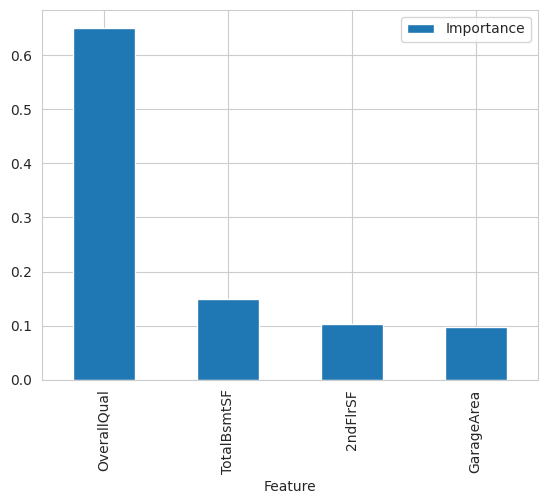

In [61]:
df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

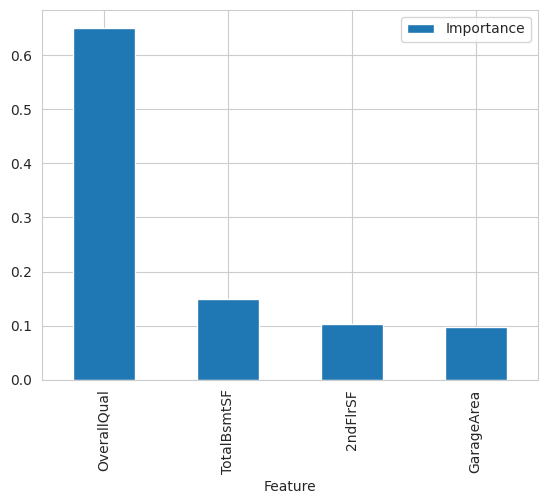

In [62]:
df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.savefig(f'{file_path}/features_importance.png', bbox_inches='tight')

Completed!